In this notebook, l explore a dataset called HeartDisese and I Build 5 machine learning models to predict 
whether a person has a heart disease or not based on the following variables:
Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS,RestingECG, MaxHR, ExerciseAngina, Oldpeak and ST_Slope


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyforest
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score

In [53]:
import os
os.chdir(r'C:\Users\BIADI\Desktop\Project ML')
df=pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [54]:
df.shape


(918, 12)

In [55]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In our dataset, we have 11 features and one binary target variable which means we need to use classification models to predict the possibility of having a heart disease.
5 features are categorical variables and 6 are numerical variables.




In [56]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [57]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


1    508
0    410
Name: HeartDisease, dtype: int64


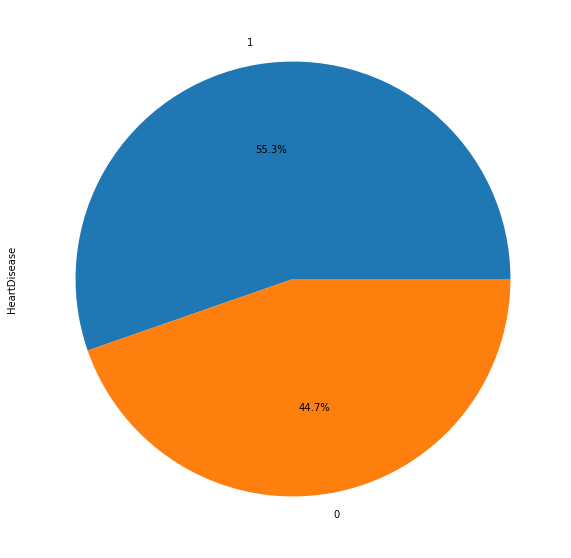

In [58]:
print(df["HeartDisease"].value_counts())
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(10,10));

In [59]:
df[df['HeartDisease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'])

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
df[df['HeartDisease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'])

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
df[numerical].iplot(kind='histogram', subplots=True,bins=50)

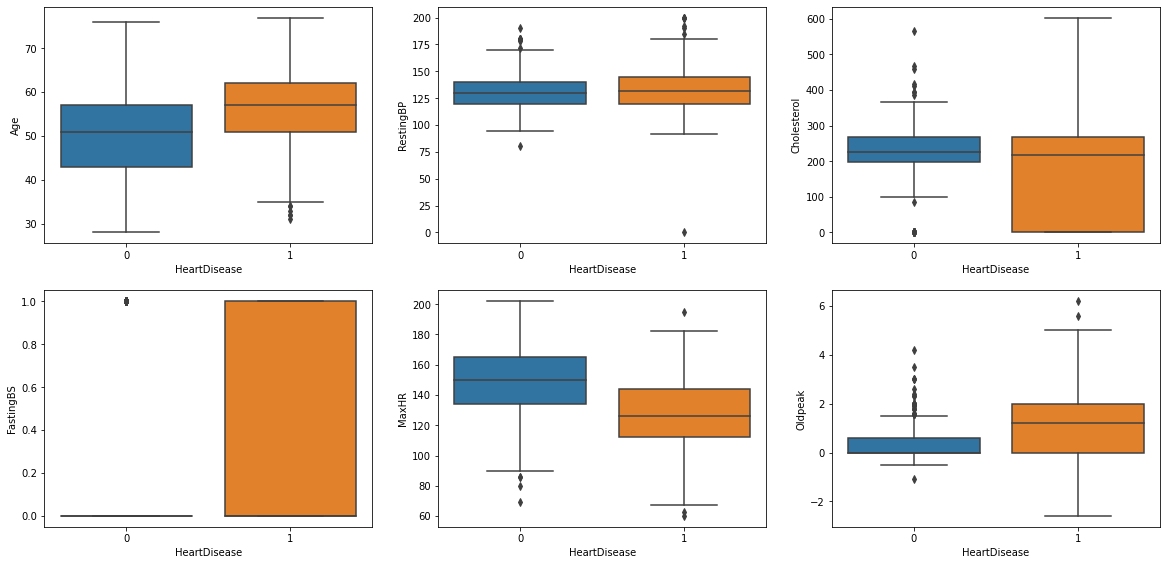

In [62]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(4, 3, index)
        sns.boxplot(x='HeartDisease', y=feature, data=df)



We can see that in general people who have a heart disease tend to be older than healthy people, have lower cholesterol levels, lower MaxHR and higher oldpeak.

Before going any further we need to transform categorical variables to numerical variables.
To do so we use get_dummy function.

In [63]:
#Before going any further we need to transform categorical variables to numerical variables.
#To do so we use get_dummy function.


In [64]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [65]:
X = df.drop(["HeartDisease"], axis=1) # A matrix that contains all the features
y = df["HeartDisease"] # the target variable

In [66]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)



<IPython.core.display.Javascript object>

In [67]:
# FEATURE SCALING
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<IPython.core.display.Javascript object>

### Modelling Logistic Regression 


In [68]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

<IPython.core.display.Javascript object>

,train_set,test_set
Accuracy,0.861538,0.876812
Precision,0.866516,0.864198
Recall,0.886574,0.921053
f1,0.876430,0.891720


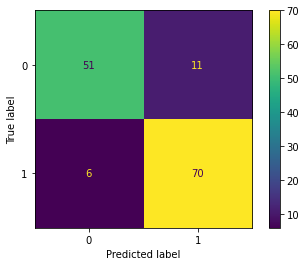

In [69]:
import pyforest
LR_model = LogisticRegression()
LR_model.fit(X_train_scaled, y_train)
y_pred = LR_model.predict(X_test_scaled)
y_train_pred = LR_model.predict(X_train_scaled)
log_f1 = f1_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(LR_model, X_test_scaled, y_test)
train_val(y_train, y_train_pred, y_test, y_pred)

In [70]:
#Tuning the model and using cross validation to improve it


In [71]:
penalty = ["l1", "l2", "elasticnet"]
l1_ratio = np.linspace(0, 1, 20)
C = np.logspace(0, 10, 20)

param_grid = {"penalty" : penalty,
             "l1_ratio" : l1_ratio,
             "C" : C}
LR_grid_model = LogisticRegression(solver='saga', max_iter=5000, class_weight = "balanced")

LR_grid_model = GridSearchCV(LR_grid_model, param_grid = param_grid)
LR_grid_model.fit(X_train_scaled, y_train)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

C:\Users\BIADI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning:

l1_ratio parameter

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000, solver='saga'),
             param_grid={'C': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})

,train_set,test_set
Accuracy,0.867949,0.876812
Precision,0.885246,0.883117
Recall,0.875000,0.894737
f1,0.880093,0.888889


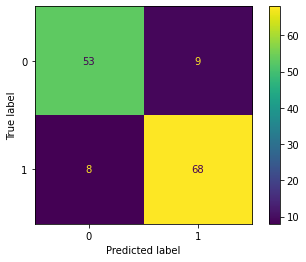

In [72]:
y_pred = LR_grid_model.predict(X_test_scaled)
y_train_pred = LR_grid_model.predict(X_train_scaled)
log_grid_f1 = f1_score(y_test, y_pred)
log_grid_acc = accuracy_score(y_test, y_pred)
log_grid_recall = recall_score(y_test, y_pred)
log_grid_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(LR_grid_model, X_test_scaled, y_test)
train_val(y_train, y_train_pred, y_test, y_pred)

### Support Vector Machine (SVM)

,train_set,test_set
Accuracy,0.883333,0.891304
Precision,0.881432,0.896104
Recall,0.912037,0.907895
f1,0.896473,0.901961


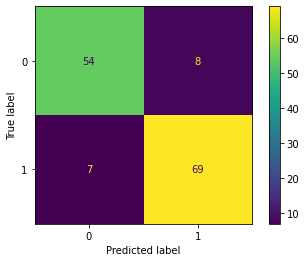

In [73]:
from sklearn.svm import SVC
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train_scaled, y_train)
y_pred = SVM_model.predict(X_test_scaled)
y_train_pred = SVM_model.predict(X_train_scaled)
svm_f1 = f1_score(y_test, y_pred)
svm_acc = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(SVM_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [74]:
#Modelling Support Vector Machine (SVM) with Best Parameters Using GridSeachCV
param_grid = {'C': [0.1,1, 10, 100, 1000],
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}
SVM_grid_model = SVC(random_state=42)
SVM_grid_model = GridSearchCV(SVM_grid_model, param_grid, verbose=3, refit=True)
SVM_grid_model.fit(X_train_scaled, y_train)
y_pred = SVM_grid_model.predict(X_test_scaled)
y_train_pred = SVM_grid_model.predict(X_train_scaled)


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 2/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 3/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 4/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 5/5] END ..............C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=aut

[CV 5/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 2/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 3/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 4/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 5/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV 1/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END .................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   0.0s
[CV 1/5] END .................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C=100, gamma=scale, kernel=linear; total time=   0.0s
[CV 2/5] END ..............C=100, gamma=scale, kernel=linear; total time=   0.0s
[CV 3/5] END ..............C=100, gamma=scale, kernel=linear; total time=   0.0s
[CV 4/5] END ..............C=100, gamma=scale, kernel=linear; total time=   0.0s
[CV 5/5] END ..............C=100, gamma=scale, kernel=linear; total time=   0.0s
[CV 1/5] END ..................C=100, gamma=auto, kernel=rbf; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 5/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   0.0s
[CV 1/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   0.7s
[CV 2/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   0.6s
[CV 3/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   0.4s
[CV 4/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   0.6s
[CV 5/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   0.8s
[CV 1/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END ..............C

,train_set,test_set
Accuracy,0.873077,0.898551
Precision,0.874157,0.897436
Recall,0.900463,0.921053
f1,0.887115,0.909091


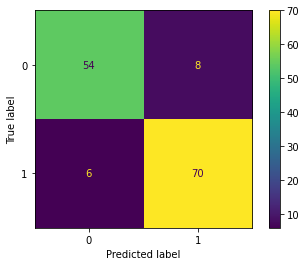

In [75]:
svm_grid_f1 = f1_score(y_test, y_pred)
svm_grid_acc = accuracy_score(y_test, y_pred)
svm_grid_recall = recall_score(y_test, y_pred)
svm_grid_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(SVM_grid_model, X_test_scaled, y_test)
train_val(y_train, y_train_pred, y_test, y_pred)

We improved the recall by 0.02 whish is a good thing if we take into consideration that our goal is to predict heart failure for all potential cases

### Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
DT_model.fit(X_train_scaled, y_train)
y_pred = DT_model.predict(X_test_scaled)
y_train_pred = DT_model.predict(X_train_scaled)

,train_set,test_set
Accuracy,1.0,0.731884
Precision,1.0,0.753247
Recall,1.0,0.763158
f1,1.0,0.758170


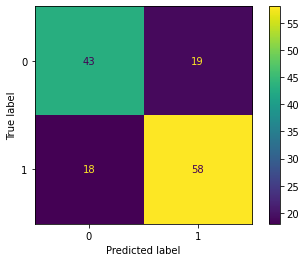

In [77]:
dt_f1 = f1_score(y_test, y_pred)
dt_acc = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_pred)

plot_confusion_matrix(DT_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [78]:
#Modelling DT with Best Parameters Using GridSeachCV
param_grid = {"splitter":["best", "random"],
              "max_features":[None, 3, 5, 7],
              "max_depth": [None, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 9, 15]}
DT_grid_model = DecisionTreeClassifier(class_weight = "balanced", random_state=42)

DT_grid_model = GridSearchCV(estimator=DT_grid_model,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)
y_pred = DT_grid_model.predict(X_test_scaled)
y_train_pred = DT_grid_model.predict(X_train_scaled)

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


,train_set,test_set
Accuracy,0.878205,0.913043
Precision,0.889145,0.932432
Recall,0.891204,0.907895
f1,0.890173,0.920000


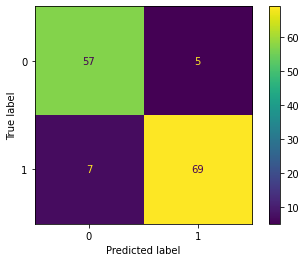

In [79]:
dt_grid_f1 = f1_score(y_test, y_pred)
dt_grid_acc = accuracy_score(y_test, y_pred)
dt_grid_recall = recall_score(y_test, y_pred)
dt_grid_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(DT_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

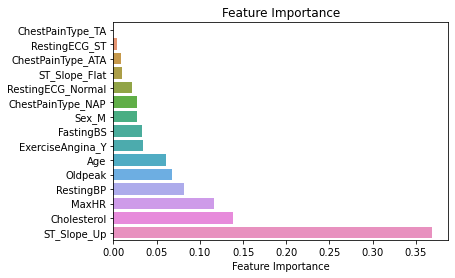

In [80]:
DT_feature_imp = pd.DataFrame(index=X.columns, data = DT_model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

We can see that ST_slop is the most important feature in making predictions


### Random Forest

<IPython.core.display.Javascript object>

,train_set,test_set
Accuracy,1.0,0.898551
Precision,1.0,0.887500
Recall,1.0,0.934211
f1,1.0,0.910256


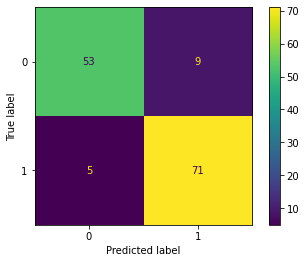

In [81]:
RF_model = RandomForestClassifier(class_weight="balanced", random_state=101)
RF_model.fit(X_train_scaled, y_train)
y_pred = RF_model.predict(X_test_scaled)
y_train_pred = RF_model.predict(X_train_scaled)
plot_confusion_matrix(RF_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

In [82]:
#Modelling Random Forest (RF) with Best Parameters 
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}
RF_grid_model = RandomForestClassifier(random_state=101)

RF_grid_model = GridSearchCV(estimator=RF_grid_model, 
                             param_grid=param_grid, 
                             scoring = "recall", 
                             n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,train_set,test_set
Accuracy,1.0,0.898551
Precision,1.0,0.887500
Recall,1.0,0.934211
f1,1.0,0.910256


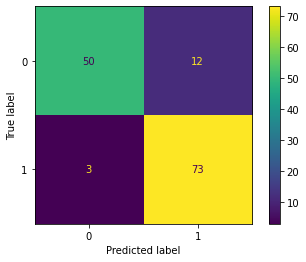

In [83]:
rf_grid_f1 = f1_score(y_test, y_pred)
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)
rf_grid_auc = roc_auc_score(y_test, y_pred)
plot_confusion_matrix(RF_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

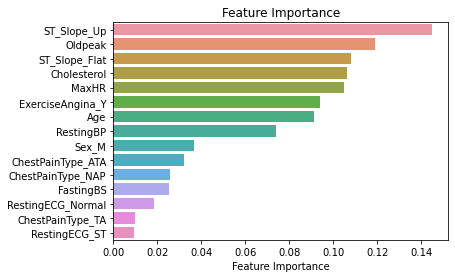

In [84]:
RF_feature_imp = pd.DataFrame(index = X.columns, data = RF_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

We can clearly see that Random forest takes into consideration all the features to make the prediction which wasn't the case with decision tree, akso we got better results than DT

### GradientBoosting (GB)

<IPython.core.display.Javascript object>

,train_set,test_set
Accuracy,0.939744,0.920290
Precision,0.936508,0.922078
Recall,0.956019,0.934211
f1,0.946163,0.928105


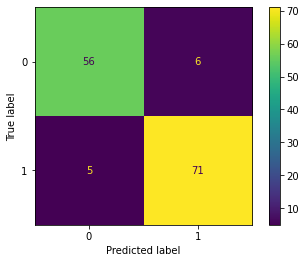

In [85]:
GB_model = GradientBoostingClassifier(random_state=42)
GB_model.fit(X_train_scaled, y_train)
y_pred = GB_model.predict(X_test_scaled)
y_train_pred = GB_model.predict(X_train_scaled)


gb_f1 = f1_score(y_test, y_pred)
gb_acc = accuracy_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

plot_confusion_matrix(GB_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,train_set,test_set
Accuracy,0.806410,0.833333
Precision,0.827506,0.819277
Recall,0.821759,0.894737
f1,0.824623,0.855346


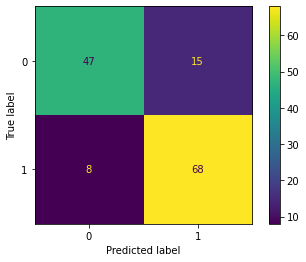

In [86]:
#Modelling GradientBoosting (GB) Model with Best Parameters Using GridSeachCV
param_grid = {"n_estimators":[100, 200, 300],
             "subsample":[0.5, 1], "max_features" : [None, 2, 3, 4], "learning_rate": [0.2, 0.5, 0.6, 0.75, 0.85, 1.0, 1.25, 1.5]}
GB_grid_model = GradientBoostingClassifier(random_state=42)

GB_grid_model = GridSearchCV(GB_grid_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

gb_grid_f1 = f1_score(y_test, y_pred)
gb_grid_acc = accuracy_score(y_test, y_pred)
gb_grid_recall = recall_score(y_test, y_pred)
gb_grid_auc = roc_auc_score(y_test, y_pred)
y_pred = GB_grid_model.predict(X_test_scaled)
y_train_pred = GB_grid_model.predict(X_train_scaled)


plot_confusion_matrix(GB_grid_model, X_test_scaled, y_test)

train_val(y_train, y_train_pred, y_test, y_pred)

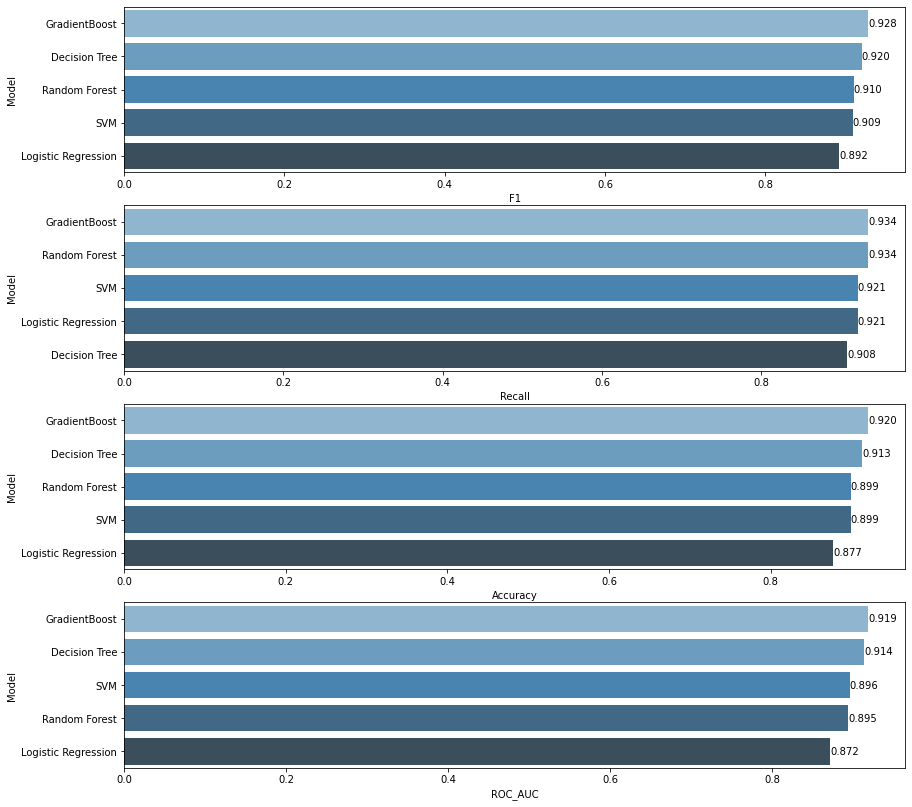

In [87]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "Decision Tree", "Random Forest", "GradientBoost"],
                        "F1": [log_f1, svm_grid_f1, dt_grid_f1, rf_grid_f1, gb_f1 ],
                        "Recall": [log_recall, svm_grid_recall, dt_grid_recall, rf_grid_recall, gb_recall],
                        "Accuracy": [log_acc, svm_grid_acc, dt_grid_acc, rf_grid_acc, gb_acc],
                        "ROC_AUC": [log_auc, svm_grid_auc, dt_grid_auc, rf_grid_auc, gb_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,14))
plt.subplot(411)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(413)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(414)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()



We can conclude that gradient boost model is the best one that fits our data, LogisticRegression was the worst among all the models.
